In [4]:
from PIL import Image

from math import pi, sqrt, log
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

def normal(x, n, sigma, mu):
    return n * np.exp(-(((x - mu) / sigma) ** 2) / 2) / (sigma * sqrt(2 * pi))

In [91]:
sigmas = []

for i in range(12):
	img = np.asarray(Image.open(f"lab/images/pos-{i}.tif"))

	a = img[:, :, 0]
	ind = np.unravel_index(np.argmax(a, axis=None), a.shape)

	fig, ax = plt.subplots()
	ax.plot(img[:, ind[1], 0])
	y = img[:, ind[1], 0]
	x = np.arange(y.shape[0])

	(n, sigma, mu) = curve_fit(normal, x, y, p0=(200, 400, 10))[0]

	sigmas.append(sigma)

	ax.plot(x, y)
	ax.plot(x, normal(x, n, sigma, mu))

	plt.savefig(f"lab/plots/plot-{i}.png")
	plt.close()

Distancia focal: 8.720750969346986cm


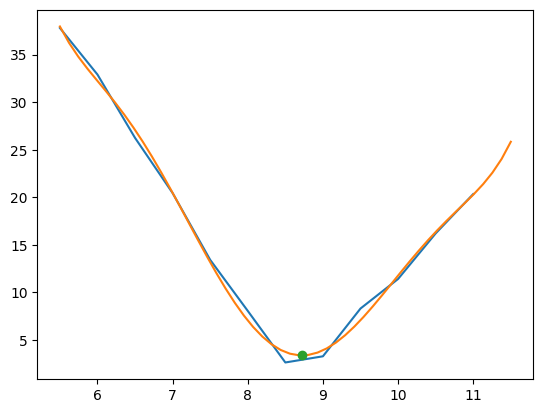

In [90]:
from numpy.polynomial.polynomial import Polynomial


def eval_poly(x, coef):
    result = 0
    for i, c in enumerate(coef):
        result += c * (x**i)

    return result

start = 11.5 - 0.5 * 12
end = 11.5

fig, ax = plt.subplots()
x = np.arange(start, end, step=0.5)
y = sigmas[::-1]

poly = Polynomial.fit(x, y, 6)
coef = poly.convert().coef

rts = poly.deriv().roots()
rt = [i for i in rts if 8 < i.real < 9][0].real
print(f"Distancia focal: {rt.real}cm")

ax.plot(x, y)

_x = np.linspace(start, end, num=50)
ax.plot(_x, eval_poly(_x, coef))
ax.plot(rt, eval_poly(rt, coef), "o")

Sigma: 45.75000789867486
Mu: 392.0660907863463
FWHM: 107.74126860137929
Linewidth: 0.5009688413743821 mm


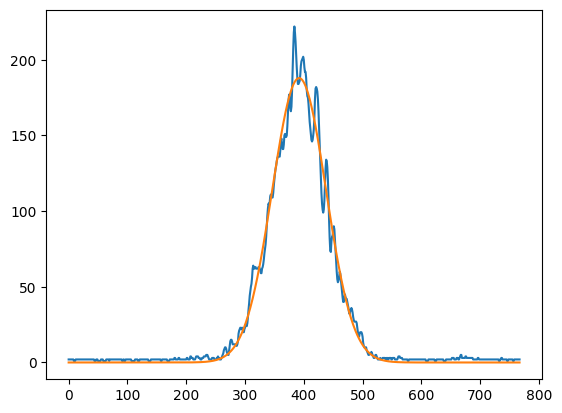

In [2]:
img = np.asarray(Image.open(f"lab/images/LaserCintura.tif"))

a = img[:, :, 0]
ind = np.unravel_index(np.argmax(a, axis=None), a.shape)

fig, ax = plt.subplots()
y = img[:, ind[1], 0]
x = np.arange(y.shape[0])

(n, sigma, mu) = curve_fit(normal, x, y, p0=(200, 400, 10))[0]

ax.plot(x, y)
ax.plot(x, normal(x, n, sigma, mu))

print(f"Sigma: {sigma}")
print(f"Mu: {mu}")
print(f"FWHM: {2.355 * sigma}")
print(f"Linewidth: {3.571 / y.shape[0] * 2.355 * sigma} mm")

Sigma: 97.79557969732285
Mu: 375.89435794625075
FWHM: 230.3085901871953
Linewidth: 1.070874968175097 mm


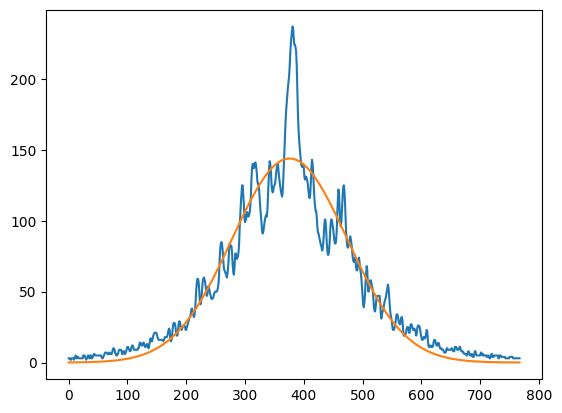

In [3]:
img = np.asarray(Image.open(f"lab/images/FibraCintura.tif"))

a = img[:, :, 0]
ind = np.unravel_index(np.argmax(a, axis=None), a.shape)

fig, ax = plt.subplots()
y = img[:, ind[1], 0]
x = np.arange(y.shape[0])

(n, sigma, mu) = curve_fit(normal, x, y, p0=(200, 400, 10))[0]

ax.plot(x, y)
ax.plot(x, normal(x, n, sigma, mu))

print(f"Sigma: {sigma}")
print(f"Mu: {mu}")
print(f"FWHM: {2.355 * sigma}")
print(f"Linewidth: {3.571 / y.shape[0] * 2.355 * sigma} mm")